# We Rate Dogs


## Introduction

This project was submitted as part of Udacity's Data Analyst Nanodegree program. Within this notebook data wrangling techniques are used to obtain data that is analyzed and visualized. The project motivation is to gain insights about the top dog breeds rated by [WeRateDogs](https://twitter.com/dog_rates9).

## Table of Contents
1. [Data Wrangling](#wrangling)
<br>1.1. [Gathering Data](#gathering)
<br>1.2. [Assessing Data](#assessing)
<br>1.2.1. [Visual Assessment](#visual)
<br>1.2.2. [Programmatic Assessment](#programmatic)
<br>1.2.3. [Quality](#a-quality)
<br>1.2.4. [Tidiness](#a-tidiness)
<br>1.3. [Cleaning Data](#cleaning)
<br>1.3.1. [Missing Data](#missing)
<br>1.3.2. [Tidiness](#c-tidiness)
<br>1.3.3. [Quality](#c-quality)

1. [Storing, Analyzing & Visualizing Data](#sav-data)
<br>2.1. [Storing Data](#storing)
<br>2.2. [Analyzing Data](#analyzing)
 <br>Following insights are determined:
 1. [Top 10 dog breeds most times rated](#i1)
 1. [Top 10 dog breeds very rarely rated](#i2)
 1. [Top 3 rated dog breeds](#i3)
 1. [Worst 3 rated dog breeds](#i4)
 1. [Top 3 dog breeds with highest retweet count](#i5)
 1. [Worst 3 dog breeds with highest favorite count](#i6)
 1. [Top 10 dog breeds with highest rating sum](#i7)
 1. [Top 10 dog breeds with highest favorite count sum](#i8)
 1. [Top 10 dog breeds with highest retweet count sum](#i9)
   
   2.3. [Visualizing Data](#visualizing)
    <br>Following illustrations are provided: 
    1. [Favorite and Retweet Count for Dog Breeds in Top 10 Intersection of Favorite Count, Retweet Count and Rating](#v1)

In [1]:
# Import required modules
import numpy as np
import pandas as pd
import json, os, requests, tweepy
from io import StringIO
from pprint import pprint
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as mticker

<a id='wrangling'></a>
# 1. Data Wrangling
<a id='gathering'></a>
## 1.1. Gathering Data
The data will be gathered from 3 different data sources:
1. The WeRateDogs Twitter archive `data/twitter-archive-enhanced.csv` has been provided by Udacity. The file will be loaded into a dedicated DataFrame called `df_archive` using pandas.
1. The file `data/image_predictions.tsv` is hosted on Udacity's servers and will be downloaded programmatically using the Requests library. It contains the tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. The file will be loaded into a dedicated DataFrame called `df_img` using pandas.
1. Using the tweet IDs in the WeRateDogs Twitter archive, the Twitter API for each tweet's JSON data using Python's Tweepy library was queried. Each tweet's entire set of JSON data will be stored i a file called `data/tweet_json.txt file`. Each tweet's JSON data is stored to its own line. The tweet ID, retweet count, and favorite count will be loaded from this file into a dedicated DataFrame called `df_api` using pandas. To avoid exposing the Twitter developer accounts credentials used for accessing the Twitter API, the API Key was set as environment vairable `CONSUMER_KEY` and the secret as environment vairable `CONSUMER_SECRET`.

In [2]:
# WeRateDogs Twitter archive, read file as DataFrame
df_archive = pd.read_csv('data/twitter-archive-enhanced.csv')
df_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [3]:
# The tweet image predictions file hosted on Udacity's servers
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
# Download file
img_predicts_file = os.path.join('data', url[url.rfind('/')+1:])
r = requests.get(url)
with open(img_predicts_file, 'wb') as f:
    f.write(r.content)
# Read file as DataFrame
df_img = pd.read_csv(img_predicts_file, sep='\t')
df_img.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


**IMPORTANT** To run the code of the following cell, please ensure that you set your Twitter developer accounts API Key as environment vairable `CONSUMER_KEY` and your secret as environment vairable `CONSUMER_SECRET`.

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file

# Read API key and secret from environment variables
consumer_key = os.environ.get("CONSUMER_KEY")
consumer_secret = os.environ.get("CONSUMER_SECRET")

# Get OAuthHandler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Get API
api = tweepy.API(auth, wait_on_rate_limit=True)

# Get tweet ids for which to gather additional data via Twitter's API
tweet_ids = df_archive.tweet_id.values
tweet_count = len(tweet_ids)
print('Number fo tweets to be fetched from Twitter API: {}\nTweets fetched ...'.format(tweet_count))

# Initialize counter, timer and dictionary storing errors for each tweet id for which data couldn't be queried succesful
count = 0
start = timer()
fails_dict = {}

# Open and write new file
with open('data/tweet_json.txt', 'w') as f:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        if count % 50 == 0:
            print('... {}/{}'.format(count, tweet_count))
        try:
            # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            # Save each tweet's returned JSON as a new line in a .txt file
            json.dump(tweet._json, f)
            f.write('\n')
        except tweepy.TweepError as e:
            # Store errors for each tweet id
            fails_dict[tweet_id] = e
end = timer()
print('... finished\n\nDuration in seconds: '.format(end - start))

Number fo tweets to be fetched from Twitter API: 2356
Tweets fetched ...
... 50/2356
... 100/2356
... 150/2356
... 200/2356
... 250/2356
... 300/2356
... 350/2356
... 400/2356
... 450/2356
... 500/2356
... 550/2356
... 600/2356
... 650/2356
... 700/2356
... 750/2356
... 800/2356
... 850/2356
... 900/2356
... 950/2356
... 1000/2356
... 1050/2356
... 1100/2356
... 1150/2356
... 1200/2356
... 1250/2356
... 1300/2356
... 1350/2356
... 1400/2356
... 1450/2356
... 1500/2356
... 1550/2356
... 1600/2356
... 1650/2356
... 1700/2356
... 1750/2356
... 1800/2356
... 1850/2356
... 1900/2356
... 1950/2356
... 2000/2356
... 2050/2356
... 2100/2356
... 2150/2356
... 2200/2356
... 2250/2356
... 2300/2356
... 2350/2356
... finished

Duration in seconds: 


In [5]:
print('Failed to fetch tweets:')
pprint(fails_dict)

Failed to fetch tweets:
{680055455951884288: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 754011816964026368: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 759566828574212096: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 770743923962707968: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 771004394259247104: TweepError([{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]),
 775096608509886464: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 779123168116150273: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 802247111496568832: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 812747805718642688: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 827228250799742977: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]),
 829374341691346

In [6]:
retry_dict = {}
for k, v in fails_dict.items():
    # Code 144 means that the tweet does not exist
    # Code 176 means that I am not authorized to see this tweet
    if v.api_code not in (144, 179):
        retry_dict[k] = v
print('Retry fetching tweets without error 144 or 179 on first try:')
pprint(retry_dict)

Retry fetching tweets without error 144 or 179 on first try:
{}


In [7]:
# Print first line as example output for visual inspection
with open('data/tweet_json.txt') as f:
    io = StringIO(f.readline())
    j = json.load(io)
pprint(j)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
              'media': [{'display_url': 'pic.twitter.com/MgUWQ76dJU',
                         'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
                         'id': 892420639486877696,
                         'id_str': '892420639486877696',
                         'indices': [86, 109],
                         'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
                         'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
                         'sizes': {'large': {'h': 528,
                                             'resize': 'fit',
                                             'w': 540},
                                   'medium': {'h': 528,
                                              'resize': 'fit',
                                    

In [8]:
dict_api = {}
# Get tweet id, favorite_count and retweet_count from JSON API output per tweet
columns_api = ['id', 'favorite_count', 'retweet_count']
with open('data/tweet_json.txt') as f:
    count = 0
    # Each line represents the JSON API output per tweet
    for line in f:
        io = StringIO(line)
        j = json.load(io)
        # For each tweet a new key to the dictionary and assign the relevant JSON API outputs as list to it
        dict_api[count] = [j.get(c, np.nan) for c in columns_api]
        count += 1

In [9]:
# Read the dictionary as DataFrame
# Each row is represented by a key
df_api = pd.DataFrame.from_dict(dict_api, orient='index', columns=columns_api)
df_api.head(1)

,id,favorite_count,retweet_count
0,892420643555336193,34860,7315


<a id='assessing'></a>
## 1.2. Assessing Data
After gathering each of the above pieces of data, the data will be visually and programmatically assessed for quality and tidiness issues. The columns of each DataFrame will be described. The detected issues will be documented. Only issues that help to satisfy the project motivation will be covered.

<a id='visual'></a>
### 1.2.1. Visual Assessment

In [10]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [11]:
df_img

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [12]:
df_api

,id,favorite_count,retweet_count
0,892420643555336193,34860,7315
1,892177421306343426,30194,5465
2,891815181378084864,22732,3604
3,891689557279858688,38132,7505
4,891327558926688256,36396,8057
...,...,...,...
2326,666049248165822465,92,38
2327,666044226329800704,258,121
2328,666033412701032449,105,39
2329,666029285002620928,117,41


<a id='programmatic'></a>
### 1.2.2. Programmatic Assessment

In [13]:
df_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [14]:
df_archive.tail(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [15]:
df_img.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [16]:
df_img.tail(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [17]:
df_api.head(3)

,id,favorite_count,retweet_count
0,892420643555336193,34860,7315
1,892177421306343426,30194,5465
2,891815181378084864,22732,3604


In [18]:
df_api.tail(3)

,id,favorite_count,retweet_count
2328,666033412701032449,105,39
2329,666029285002620928,117,41
2330,666020888022790149,2338,442


In [19]:
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
610,797236660651966464,NaN,NaN,2016-11-12 00:36:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pancake. She loves Batman and winks li...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/797236660...,12,10,Pancake,None,None,None,None
1079,739238157791694849,NaN,NaN,2016-06-04 23:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739238157...,13,10,None,doggo,None,None,None
1924,674075285688614912,NaN,NaN,2015-12-08 03:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mitch. He thinks that's a hat. No...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674075285...,11,10,Mitch,None,None,None,None
247,845459076796616705,NaN,NaN,2017-03-25 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a heartwarming scene of ...,7.562885e+17,4.196984e+09,2016-07-22 00:43:32 +0000,https://twitter.com/dog_rates/status/756288534...,12,10,None,None,None,None,None
688,787810552592695296,NaN,NaN,2016-10-17 00:20:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Frank. He wears sunglasses and walks h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/787810552...,11,10,Frank,None,None,None,None


In [20]:
df_img.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1043,712668654853337088,https://pbs.twimg.com/media/CePoVTyWsAQEz1g.jpg,1,Labrador_retriever,0.829058,True,golden_retriever,0.038664,True,Chihuahua,0.026221,True
559,677700003327029250,https://pbs.twimg.com/media/CWesj06W4AAIKl8.jpg,1,Siberian_husky,0.120849,True,junco,0.079206,False,malamute,0.063088,True
771,689517482558820352,https://pbs.twimg.com/media/CZGofjJW0AINjN9.jpg,1,Pembroke,0.799319,True,Cardigan,0.189537,True,papillon,0.003386,True
820,692919143163629568,https://pbs.twimg.com/media/CZ2-SRiWcAIjuM5.jpg,1,Saint_Bernard,0.612635,True,English_springer,0.269744,True,boxer,0.048666,True
178,669216679721873412,https://pbs.twimg.com/media/CUmJBS5WUAAKtrP.jpg,1,golden_retriever,0.992758,True,Irish_setter,0.003379,True,Saluki,0.001230,True


In [21]:
df_api.sample(5)

,id,favorite_count,retweet_count
52,881906580714921986,22092,2960
655,789628658055020548,7337,1721
1145,720785406564900865,2951,724
2052,670833812859932673,397,113
1567,686606069955735556,1809,516


In [22]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Column description table `df_archive`

* `tweet_id` is the last part of the tweet URL after "status/", e.g. https://twitter.com/dog_rates/status/892420643555336193/
* `in_reply_to_status_id` will contain the integer representation of the original Tweet’s ID, if the represented Tweet is a reply
* `in_reply_to_user_id` will contain the integer representation of the original Tweet’s author ID, if the represented Tweet is a reply
* `timestamp` is the UTC time when this Tweet was created
* `source` is the Utility used to post the Tweet, as an HTML-formatted string
* `text` is the actual UTF-8 text of the status update
* `retweeted_status_id` will contain the integer representation of the original Tweet’s ID, if the represented Tweet is a retweet
* `retweeted_status_user_id` will contain the integer representation of the original Tweet’s author ID, if the represented Tweet is a retweet
* `retweeted_status_timestamp` will contain the UTC time when the original Tweet was created, if the represented Tweet is a retweet
* `expanded_urls` expanded version of the URL pasted/typed into Tweet
* `rating_numerator` the rating numerator defining the rating of the specifc dog associated with this tweet
* `rating_denominator` the rating denominator defining the rating of the specifc dog associated with this tweet
* `name` the name of the specifc dog associated with this tweet
* `doggo` is a dog stage
* `floofer` is a dog stage
* `pupper` is a dog stage
* `puppo` is a dog stage

In [23]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Column description table `df_img`

* `tweet_id` is the last part of the tweet URL after "status/", e.g. https://twitter.com/dog_rates/status/892420643555336193/
* `jpg_url` is the URL to the image
* `img_num` is the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
* `p1` is the algorithm's #1 prediction for the image in the tweet
* `p1_conf` is how confident the algorithm is in its #1 prediction
* `p1_dog` is whether or not the #1 prediction is a breed of dog
* `p2` is the algorithm's second most likely prediction
* `p2_conf` is how confident the algorithm is in its #2 prediction
* `p2_dog` is whether or not the #2 prediction is a breed of dog
* `p3` is the algorithm's second most likely prediction
* `p3_conf` is how confident the algorithm is in its #2 prediction
* `p3_dog` is whether or not the #2 prediction is a breed of dog

In [24]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 72.8 KB


### Column description table `df_api`

* `id` is the last part of the tweet URL after "status/", e.g. https://twitter.com/dog_rates/status/892420643555336193/
* `favorite_count` indicates approximately how many times this Tweet has been liked by Twitter users
* `retweet_count` is the number of times the tweet has been retweeted

In [25]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [26]:
df_img.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [27]:
df_api.describe()

,id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7279.900901,2573.211068
std,6.823170e+16,11308.703127,4352.588605
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1260.000000,522.000000
50%,7.182469e+17,3152.000000,1199.000000
75%,7.986692e+17,8894.500000,2979.000000
max,8.924206e+17,149760.000000,73824.000000


In [28]:
# Check, if any column is listed in more than one df
all_columns = pd.Series(list(df_archive) + list(df_img) + list(df_api))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

In [29]:
# Check for duplicates
df_archive[df_archive.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [30]:
df_img[df_img.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [31]:
df_api[df_api.duplicated()]

,id,favorite_count,retweet_count


In [32]:
df_archive[df_archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [33]:
# Check if retweeted* columns count not null is equal
df_archive.retweeted_status_id.notnull().sum() == df_archive.retweeted_status_timestamp.notnull().sum() == df_archive.retweeted_status_user_id.notnull().sum()

True

In [34]:
# Check if retweeted* columns count not null is on the same index position
((df_archive.retweeted_status_id.notnull().values == df_archive.retweeted_status_timestamp.notnull().values) == (
df_archive.retweeted_status_timestamp.notnull().values == df_archive.retweeted_status_user_id.notnull().values)).all()

True

In [35]:
# Display tweets that are replies
df_archive[df_archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [36]:
# Check if in_reply* columns count not null is equal
df_archive.in_reply_to_status_id.notnull().sum() == df_archive.in_reply_to_user_id.notnull().sum() 

True

In [37]:
# Check if in_reply* columns count not null is on the same index position
(df_archive.in_reply_to_status_id.notnull().values == df_archive.in_reply_to_user_id.notnull().values).all()

True

In [38]:
# Check highest and lowest rating_numerator
df_archive.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [39]:
# Check highest and lowest rating_denominator
df_archive.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [40]:
# Check count of rating_numerator > 20
df_archive[df_archive.rating_numerator > 20].rating_numerator.value_counts()

420     2
75      2
960     1
44      1
27      1
666     1
121     1
24      1
26      1
182     1
84      1
50      1
1776    1
88      1
143     1
45      1
204     1
144     1
80      1
165     1
99      1
60      1
Name: rating_numerator, dtype: int64

In [41]:
# Check count of rating_numerator < 10
df_archive[df_archive.rating_numerator < 10].rating_numerator.value_counts()

9    158
8    102
7     55
5     37
6     32
3     19
4     17
1      9
2      9
0      2
Name: rating_numerator, dtype: int64

In [42]:
# Check count of rating_denominator != 10
df_archive[df_archive.rating_denominator != 10].rating_denominator.value_counts()

50     3
11     3
20     2
80     2
0      1
110    1
120    1
150    1
15     1
16     1
130    1
170    1
40     1
7      1
70     1
2      1
90     1
Name: rating_denominator, dtype: int64

In [43]:
# Number of rows rating_numerator > 20 or rating_numerator == 0 or rating_denominator != 10
df_archive.query("rating_numerator > 20 or rating_numerator == 0 or rating_denominator != 10")[['rating_numerator', 'rating_denominator']].shape[0]

34

In [44]:
# Number of images on which a dog has been identified by neural network
n_img_a_dog_org = df_img[df_img.p1_dog | df_img.p2_dog | df_img.p3_dog][['p1_dog', 'p2_dog', 'p3_dog']]
# Number of images on which not a dog has been identified by neural network
n_img_not_a_dog_org = df_img[~df_img.p1_dog & ~df_img.p2_dog & ~df_img.p3_dog][['p1_dog', 'p2_dog', 'p3_dog']]
print('Number of a dog image predictions: {}, '.format(n_img_a_dog_org.shape[0]) +
      'Number of not a dog image predictions: {}'.format(n_img_not_a_dog_org.shape [0]))
assert n_img_a_dog_org.shape[0] + n_img_not_a_dog_org.shape[0] == df_img.shape[0]

Number of a dog image predictions: 1751, Number of not a dog image predictions: 324


In [45]:
# 5 random images on which a dog has been identified by neural network
df_img[df_img.p1_dog | df_img.p2_dog | df_img.p3_dog].sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
904,700143752053182464,https://pbs.twimg.com/media/CbdpBmLUYAY9SgQ.jpg,1,golden_retriever,0.532460,True,crossword_puzzle,0.103796,False,binder,0.100371,False
1582,796759840936919040,https://pbs.twimg.com/media/Cw6o1JQXcAAtP78.jpg,1,American_Staffordshire_terrier,0.463996,True,Staffordshire_bullterrier,0.155566,True,Weimaraner,0.137587,True
180,669327207240699904,https://pbs.twimg.com/media/CUntin8WIAADmLk.jpg,1,golden_retriever,0.919584,True,Labrador_retriever,0.049669,True,kuvasz,0.010216,True
1316,755110668769038337,https://pbs.twimg.com/ext_tw_video_thumb/75511...,1,Labrador_retriever,0.708974,True,golden_retriever,0.114314,True,Great_Pyrenees,0.065813,True
113,667915453470232577,https://pbs.twimg.com/media/CUTpj-GWcAATc6A.jpg,1,leatherback_turtle,0.452517,False,boxer,0.196655,True,terrapin,0.160983,False


In [46]:
# 5 random images on which not a dog has been identified by neural network
df_img[~df_img.p1_dog & ~df_img.p2_dog & ~df_img.p3_dog].sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
260,670783437142401025,https://pbs.twimg.com/media/CU8Z-OxXAAA-sd2.jpg,1,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False
1448,776113305656188928,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,1,mousetrap,0.777468,False,black_widow,0.093940,False,paddlewheel,0.017492,False
470,675113801096802304,https://pbs.twimg.com/media/CV58a4nXAAApywo.jpg,1,bow,0.168020,False,quill,0.108807,False,joystick,0.043312,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,0.012601,False,coyote,0.000057,False
1312,754482103782404096,https://pbs.twimg.com/ext_tw_video_thumb/75448...,1,tub,0.596796,False,bathtub,0.381098,False,shower_curtain,0.017629,False


In [47]:
# Number of tweets were dog name is 'None'
df_archive[df_archive.name == 'None'].name.count()

745

In [48]:
# 5 Tweet texts were Dog Name is 'None'
df_archive[df_archive.name == 'None'].text.values[:5]

array(["Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh",
       "When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq",
       "Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm",
       'You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV',
       'This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp'],
      dtype=object)

In [49]:
# Unique dog names in lower case
df_archive[df_archive.name.str.islower()].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [50]:
# 5 Tweet texts for which Dog Name is in lower case
df_archive[df_archive.name.str.islower()].text.values[:5]

array(["I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba",
       'Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF',
       "RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…",
       "We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9",
       "Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x"],
      dtype=object)

In [51]:
# Expanded URLs that do not start with http
df_archive[df_archive.expanded_urls.str.startswith('http') == False].expanded_urls

Series([], Name: expanded_urls, dtype: object)

In [52]:
# Expanded URLs that contains more than one URL separated by comma
df_archive[df_archive.expanded_urls.str.contains(',') == True].expanded_urls

4       https://twitter.com/dog_rates/status/891327558...
6       https://gofundme.com/ydvmve-surgery-for-jax,ht...
7       https://twitter.com/dog_rates/status/890729181...
10      https://twitter.com/dog_rates/status/890006608...
13      https://twitter.com/dog_rates/status/889638837...
                              ...                        
2084    https://twitter.com/dog_rates/status/670807719...
2205    https://twitter.com/dog_rates/status/668633411...
2209    https://twitter.com/dog_rates/status/668623201...
2259    https://twitter.com/dogratingrating/status/667...
2260    https://twitter.com/dogratingrating/status/667...
Name: expanded_urls, Length: 639, dtype: object

In [53]:
# JPG URLs that do not start with http
df_img[df_img.jpg_url.str.startswith('http') == False].jpg_url

Series([], Name: jpg_url, dtype: object)

In [54]:
# JPG URLs that contains more than one URL separated by comma
df_img[df_img.jpg_url.str.contains(',') == True].jpg_url

Series([], Name: jpg_url, dtype: object)

In [55]:
# Predicated dog breeds (p1) that contain - or _
df_img[df_img.p1.str.match(r'.*(-|_)')]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2061,889638837579907072,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1,French_bulldog,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True
2063,889880896479866881,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,French_bulldog,0.377417,True,Labrador_retriever,0.151317,True,muzzle,0.082981,False
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False


In [56]:
print('{:<30}{:<10}{:<15}{:<20}{:<10}{:<10}'.format('column', 'nunique', 'duplicated', 'value_counts', 'None', 'isnull'))
for c in df_archive.columns:
    print('{:<30}{:<10}{:<15}{:<20}{:<10}{:<10}'.format(c, df_archive[c].nunique(), df_archive[c].duplicated().sum(),
                                                        df_archive[c].value_counts().sum(), (df_archive[c] == 'None').sum(),
                                                        df_archive[c].isnull().sum()))

column                        nunique   duplicated     value_counts        None      isnull    
tweet_id                      2356      0              2356                0         0         
in_reply_to_status_id         77        2278           78                  0         2278      
in_reply_to_user_id           31        2324           78                  0         2278      
timestamp                     2356      0              2356                0         0         
source                        4         2352           2356                0         0         
text                          2356      0              2356                0         0         
retweeted_status_id           181       2174           181                 0         2175      
retweeted_status_user_id      25        2330           181                 0         2175      
retweeted_status_timestamp    181       2174           181                 0         2175      
expanded_urls                 2218      

In [57]:
print('{:<30}{:<10}{:<15}{:<20}{:<10}{:<10}'.format('column', 'nunique', 'duplicated', 'value_counts', 'None', 'isnull'))
for c in df_img.columns:
    print('{:<30}{:<10}{:<15}{:<20}{:<10}{:<10}'.format(c, df_img[c].nunique(), df_img[c].duplicated().sum(),
                                                        df_img[c].value_counts().sum(), (df_img[c] == 'None').sum(),
                                                        df_img[c].isnull().sum()))

column                        nunique   duplicated     value_counts        None      isnull    
tweet_id                      2075      0              2075                0         0         
jpg_url                       2009      66             2075                0         0         
img_num                       4         2071           2075                0         0         
p1                            378       1697           2075                0         0         
p1_conf                       2006      69             2075                0         0         
p1_dog                        2         2073           2075                0         0         
p2                            405       1670           2075                0         0         
p2_conf                       2004      71             2075                0         0         
p2_dog                        2         2073           2075                0         0         
p3                            408       

In [58]:
print('{:<30}{:<10}{:<15}{:<20}{:<10}{:<10}'.format('column', 'nunique', 'duplicated', 'value_counts', 'None', 'isnull'))
for c in df_api.columns:
    print('{:<30}{:<10}{:<15}{:<20}{:<10}{:<10}'.format(c, df_api[c].nunique(), df_api[c].duplicated().sum(),
                                                        df_api[c].value_counts().sum(), (df_api[c] == 'None').sum(),
                                                        df_api[c].isnull().sum()))

column                        nunique   duplicated     value_counts        None      isnull    
id                            2331      0              2331                0         0         
favorite_count                1977      354            2331                0         0         
retweet_count                 1707      624            2331                0         0         


<a id='a-quality'></a>
### 1.2.3. Quality

#### `df_archive` table
* Some tweets are retweets and should be dropped, because they might be no original ratings
* Some tweets are replies and should be dropped, because they might be no original ratings (additionally, the columns `in_reply_to_status_id` and `in_reply_to_user_id` are `float64` instead of `int64` but this extraneous)
* The `rating_denominator` sometimes does not equals 10
* The `rating_numerator` sometimes is greater than 20 and sometimes equals 0
* The columns `name`, `doggo`, `floofer`, `pupper` and `puppo` contain the string `None` instead of `np.nan` as null value
* The column `name` contains very likely not real names, i.e. `a`, `by`, `unacceptable`, `very`, `an`, `my` and `incredibly`.
* The `timestamp` and `retweeted_status_timestamp` is represented as string and should be a datetime value (only `timestamp` requires cleaning, because retweets will not be considered)

#### `df_img` table
* For some images the top 3 predications did not identified a dog
* The confidence of some predicted dog breeds is below 30%
* The predicted dog breed consisting of more than one word for p1 or p2 or p3 are separated by `_` or `-` instead of blank. Additionally, the words sometimes do not start capitalized 

#### `df_api` table
* No issues identified

<a id='a-tidiness'></a>
### 1.2.4. Tidiness
* In table `df_archive` each dog stage has it's own column (`doggo`, `floofer`, `pupper` and `puppo`), which will be changed to a single column `dog_stage`
* The table `df_archive` has tweets that are not represented in the table `df_img` and `df_api`
* The table `df_img` should be part of the `df_archive` table
* The table `df_api` should be part of the `df_archive` table

<a id='cleaning'></a>
## 1.3. Cleaning Data
Each of the [quality](#a-quality) and [tidiness issues](#a-tidiness) documented will be cleaned as follows. Initially, [missing data](#missing), followed by [tidiness](#c-tidiness) and finally, [quality issues](#c-quality) will be cleaned. The results of cleaning will be a high quality and tidy master pandas DataFrame `df_archive_clean` that is required to satisfy the Project Motivation. For each issue the cleaning process is structures by define, code, and test steps which are documented.

In [59]:
# Create copies
df_archive_clean = df_archive.copy()
df_img_clean = df_img.copy()
df_api_clean = df_api.copy()

<a id='missing'></a>
### 1.3.1. Missing Data

There are no missing data issues to be cleaned first.

<a id='c-tidiness'></a>
### 1.3.2. Tidiness

#### In table `df_archive` each dog stage has it's own column (`doggo`, `floofer`, `pupper` and `puppo`), which will be changed to a single column `dog_stage`

***Define***<br>
Replace `None` in columns `doggo`, `floofer`, `pupper` and `puppo` with `np.nan`. Create a new column `dog_stage` and concatenate each value of columns `doggo`, `floofer`, `pupper` and `puppo` to it. Using ` ` (single blank character) as separator. Ensure that `NaN` value are represented as empty string. Drop the columns `doggo`, `floofer`, `pupper` and `puppo`.

***Code***

In [60]:
dog_stage_counts = {}
dog_stage_columns = ['doggo','floofer','pupper','puppo']
for c in ['doggo', 'floofer', 'pupper' , 'puppo']:
    df_archive_clean[c].replace('None', np.nan, inplace=True)
    dog_stage_counts[c] = df_archive_clean[c].value_counts()[0]

In [61]:
df_archive_clean['dog_stage'] = df_archive_clean.doggo.str.cat(df_archive_clean.floofer, sep=' ', na_rep='').str.strip()
df_archive_clean.dog_stage = df_archive_clean.dog_stage.str.cat(df_archive_clean.pupper, sep=' ', na_rep='').str.strip()
df_archive_clean.dog_stage = df_archive_clean.dog_stage.str.cat(df_archive_clean.puppo,  sep=' ', na_rep='').str.strip()

In [62]:
df_archive_clean.drop(dog_stage_columns, axis=1, inplace = True)

In [63]:
df_archive_clean.dog_stage.replace('', np.nan, inplace=True)

***Test***

In [64]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  dog_stage                   380 n

In [65]:
# Check, if columns are dropped
assert bool([c for c in dog_stage_columns if c in df_archive_clean.columns]) == False

In [66]:
# Display value counts per old column transfered to new column
dog_stage_counts

{'doggo': 97, 'floofer': 10, 'pupper': 257, 'puppo': 30}

In [67]:
# Display value counts of new columns
df_archive_clean.dog_stage.value_counts()

pupper           245
doggo             83
puppo             29
doggo pupper      12
floofer            9
doggo puppo        1
doggo floofer      1
Name: dog_stage, dtype: int64

In [68]:
# Check programmically that value counts of old and new columns match
for dog_stage, count in dog_stage_counts.items():
    assert df_archive_clean.dog_stage.str.contains(dog_stage).sum() == count

#### The table `df_archive` has tweets that are not represented in the table `df_img` and `df_api`<br>The table `df_img` should be part of the `df_archive` table <br>The table `df_api` should be part of the `df_archive` table

***Define***<br>
Merge the table `df_archive` and `df_img` using an inner join, so that the intersection of both tables based on the key `tweet_id` creates a new table that keeps the order of the table `df_archive`. This new table overrides `df_archive`. Afterwards, merge the table `df_archive` and `df_api` using an inner join, so that the intersection of both tables based on the key `tweet_id` and `id` creates a new table that keeps the order of the table `df_archive`. This new table overrides `df_archive`. Finally, drop the column `id` of `df_archive`.

***Code***

In [69]:
df_archive_clean = df_archive_clean.merge(df_api_clean, how='inner', left_on='tweet_id', right_on='id')

In [70]:
df_archive_clean = df_archive_clean.merge(df_img_clean, how='inner', on='tweet_id')

In [71]:
df_archive_clean.drop(columns='id', inplace=True, axis=1)

***Test***

In [72]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2059 non-null   object 
 4   source                      2059 non-null   object 
 5   text                        2059 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2059 non-null   object 
 10  rating_numerator            2059 non-null   int64  
 11  rating_denominator          2059 non-null   int64  
 12  name                        2059 non-null   object 
 13  dog_stage                   318 n

In [73]:
df_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
472,798665375516884993,NaN,NaN,2016-11-15 23:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lola. She fell asleep o...,6.718968e+17,4.196984e+09,2015-12-02 03:40:57 +0000,https://twitter.com/dog_rates/status/671896809...,...,1,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
984,717047459982213120,NaN,NaN,2016-04-04 17:53:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Flávio (pronounced Baxter). He's a Ben...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717047459...,...,1,golden_retriever,0.983548,True,Labrador_retriever,0.012185,True,cocker_spaniel,0.002412,True
1044,709852847387627521,NaN,NaN,2016-03-15 21:24:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*lets out a tiny whimper and then collapses* ....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709852847...,...,2,Chihuahua,0.945629,True,Pomeranian,0.019204,True,West_Highland_white_terrier,0.010134,True
2045,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,...,1,pug,0.489814,True,bull_mastiff,0.404722,True,French_bulldog,0.048960,True
378,814638523311648768,NaN,NaN,2016-12-30 01:05:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Olivia. She's a passionate advocate of...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/814638523...,...,2,golden_retriever,0.650814,True,kuvasz,0.053281,True,cocker_spaniel,0.035440,True


In [74]:
df_archive_clean[df_archive_clean.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


<a id='c-quality'></a>
### 1.3.3. Quality

#### Some tweets are retweets and should be dropped, because they might be no original ratings

***Define***<br>
Get all row indices for which `retweeted_status_id` is not null and drop those rows. Finally, drop the columns `retweeted_status_id`, `retweeted_status_timestamp` and `retweeted_status_user_id`.

***Code***

In [75]:
retweet_columns = ['retweeted_status_id', 'retweeted_status_timestamp', 'retweeted_status_user_id']
mask_retweet = df_archive_clean.retweeted_status_id.notnull()
number_of_rows_no_retweets = df_archive_clean.shape[0] - mask_retweet.sum()
df_archive_clean.drop(index=df_archive_clean[mask_retweet].index, inplace=True)
if 0 == (df_archive_clean.retweeted_status_id.notnull().sum() + df_archive_clean.retweeted_status_timestamp.notnull().sum() +
         df_archive_clean.retweeted_status_user_id.notnull().sum()):
    df_archive_clean.drop(columns=retweet_columns, inplace=True)

***Test***

In [76]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1987 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1987 non-null   object 
 4   source                 1987 non-null   object 
 5   text                   1987 non-null   object 
 6   expanded_urls          1987 non-null   object 
 7   rating_numerator       1987 non-null   int64  
 8   rating_denominator     1987 non-null   int64  
 9   name                   1987 non-null   object 
 10  dog_stage              305 non-null    object 
 11  favorite_count         1987 non-null   int64  
 12  retweet_count          1987 non-null   int64  
 13  jpg_url                1987 non-null   object 
 14  img_num                1987 non-null   int64  
 15  p1  

In [77]:
assert bool([c for c in retweet_columns if c in df_archive_clean.columns]) == False
assert df_archive_clean.shape[0] == number_of_rows_no_retweets

#### Some tweets are replies and should be dropped, because they might be no original ratings (additionally, the columns `in_reply_to_status_id` and `in_reply_to_user_id` are `float64` instead of `int64` but this extraneous)

***Define***<br>
Get all row indices for which `in_reply_to_status_id` is not null and drop those rows. Finally, drop the columns `in_reply_to_status_id` and `in_reply_to_user_id`.

***Code***

In [78]:
reply_columns = ['in_reply_to_status_id', 'in_reply_to_user_id']
mask_reply = df_archive_clean.in_reply_to_status_id.notnull()
number_of_rows_no_replies = df_archive_clean.shape[0] - mask_reply.sum()
df_archive_clean.drop(index=df_archive_clean[mask_reply].index, inplace=True)
if 0 == df_archive_clean.in_reply_to_status_id.notnull().sum() + df_archive_clean.in_reply_to_user_id.notnull().sum():
    df_archive_clean.drop(columns=reply_columns, inplace=True)

***Test***

In [79]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1964 non-null   int64  
 1   timestamp           1964 non-null   object 
 2   source              1964 non-null   object 
 3   text                1964 non-null   object 
 4   expanded_urls       1964 non-null   object 
 5   rating_numerator    1964 non-null   int64  
 6   rating_denominator  1964 non-null   int64  
 7   name                1964 non-null   object 
 8   dog_stage           302 non-null    object 
 9   favorite_count      1964 non-null   int64  
 10  retweet_count       1964 non-null   int64  
 11  jpg_url             1964 non-null   object 
 12  img_num             1964 non-null   int64  
 13  p1                  1964 non-null   object 
 14  p1_conf             1964 non-null   float64
 15  p1_dog              1964 non-null   bool   
 16  p2    

In [80]:
assert bool([c for c in reply_columns if c in df_archive_clean.columns]) == False
assert df_archive_clean.shape[0] == number_of_rows_no_replies

####  The `rating_denominator` sometimes does not equals 10

***Define***<br>
Get all row indices for which `rating_denominator` does not equals 10 and drop those rows.

***Code***

In [81]:
mask_rating_denominator = df_archive_clean[df_archive_clean.rating_denominator != 10]
number_of_rows_no_denominator = df_archive_clean.shape[0] - mask_rating_denominator.rating_denominator.count()
df_archive_clean.drop(index=mask_rating_denominator.index, inplace=True)

***Test***

In [82]:
assert df_archive_clean.shape[0] == number_of_rows_no_denominator

In [83]:
df_archive_clean[df_archive_clean.rating_denominator != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [84]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1947 entries, 0 to 2058
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1947 non-null   int64  
 1   timestamp           1947 non-null   object 
 2   source              1947 non-null   object 
 3   text                1947 non-null   object 
 4   expanded_urls       1947 non-null   object 
 5   rating_numerator    1947 non-null   int64  
 6   rating_denominator  1947 non-null   int64  
 7   name                1947 non-null   object 
 8   dog_stage           302 non-null    object 
 9   favorite_count      1947 non-null   int64  
 10  retweet_count       1947 non-null   int64  
 11  jpg_url             1947 non-null   object 
 12  img_num             1947 non-null   int64  
 13  p1                  1947 non-null   object 
 14  p1_conf             1947 non-null   float64
 15  p1_dog              1947 non-null   bool   
 16  p2    

####  The `rating_numerator` sometimes is greater than 20 and sometimes equals 0

***Define***<br>
Get all row indices for which `rating_numerator` is greater than 20 or equals 0 and drop those rows.

***Code***

In [85]:
mask_rating_numerator = df_archive_clean.query("rating_numerator > 20 or rating_numerator < 1")
number_of_rows_no_numerator = df_archive_clean.shape[0] - mask_rating_numerator.rating_numerator.count()
df_archive_clean.drop(index=mask_rating_numerator.index, inplace=True)

***Test***

In [86]:
assert df_archive_clean.shape[0] == number_of_rows_no_numerator

In [87]:
df_archive_clean[df_archive_clean.rating_numerator > 20]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [88]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 2058
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1941 non-null   int64  
 1   timestamp           1941 non-null   object 
 2   source              1941 non-null   object 
 3   text                1941 non-null   object 
 4   expanded_urls       1941 non-null   object 
 5   rating_numerator    1941 non-null   int64  
 6   rating_denominator  1941 non-null   int64  
 7   name                1941 non-null   object 
 8   dog_stage           301 non-null    object 
 9   favorite_count      1941 non-null   int64  
 10  retweet_count       1941 non-null   int64  
 11  jpg_url             1941 non-null   object 
 12  img_num             1941 non-null   int64  
 13  p1                  1941 non-null   object 
 14  p1_conf             1941 non-null   float64
 15  p1_dog              1941 non-null   bool   
 16  p2    

####  The columns `name`, `doggo`, `floofer`, `pupper` and `puppo` contain the string `None` instead of `np.nan` as null value

***Define***<br>
For the column `name` replace the string `None` with `np.nan` as null values. The `doggo`, `floofer`, `pupper` and `puppo` do not exist anymore and the new column `dog_stage` uses `np.nan` as null values (see Tidiness cleaning). 

***Code***

In [89]:
mask = df_archive_clean.name == 'None'
number_of_dogs_no_name = mask.sum()
df_archive_clean.loc[df_archive_clean[mask].index, 'name'] = np.nan

***Test***

In [90]:
assert df_archive_clean.name.isnull().sum() == number_of_dogs_no_name

####  The column `name` contains very like not real names, i.e. `a`, `by`, `unacceptable`, `very`, `an`, `my` and `incredibly`. They all seem to start with lower letters.

***Define***<br>
For the column `name` replace the strings just containing lower letters with `np.nan` as null values. 

***Code***

In [91]:
mask = df_archive_clean.name.str.islower()
number_of_dogs_no_name += mask.sum()
df_archive_clean.loc[df_archive_clean[mask == True].index, 'name'] = np.nan

***Test***

In [92]:
assert df_archive_clean.name.isnull().sum() == number_of_dogs_no_name

In [93]:
df_archive_clean.name.nunique()

907

#### The `timestamp` and `retweeted_status_timestamp` is represented as string and should be a datetime value (only `timestamp` requires cleaning, because retweets will not be considered)


***Define***<br>
The columns `timestamp` dtype will be set to datetime64 dtype.

***Code***

In [94]:
df_archive_clean.timestamp = pd.to_datetime(df_archive_clean.timestamp)

***Test***

In [95]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 2058
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1941 non-null   int64              
 1   timestamp           1941 non-null   datetime64[ns, UTC]
 2   source              1941 non-null   object             
 3   text                1941 non-null   object             
 4   expanded_urls       1941 non-null   object             
 5   rating_numerator    1941 non-null   int64              
 6   rating_denominator  1941 non-null   int64              
 7   name                1336 non-null   object             
 8   dog_stage           301 non-null    object             
 9   favorite_count      1941 non-null   int64              
 10  retweet_count       1941 non-null   int64              
 11  jpg_url             1941 non-null   object             
 12  img_num             1941 non-null 

#### For some images the top 3 predications did not identified a dog


***Define***<br>
Select all rows and predication values for images on which either p1, p2 or p3 identified a dog and store it temporarily in a new DataFrame. Use this DataFrame to determine the indices where the p1 prediction is a dog and has the highest confidence compared to p2 and p3 prediction. Add the predicted dog breed of p1 to the new column `pred_breed` and the p1 confidence to the new colum `breed_conf`. Repeat this for p2 and p3 prediction. Finally, drop images on which p1, p2 and p3 did not identified a dog.

***Code***

In [96]:
# Get prediction values of images on which either p1, p2 or p3 identified a dog
conf_is_dog = df_archive_clean[df_archive_clean.p1_dog | df_archive_clean.p2_dog | df_archive_clean.p3_dog][
    ['p1', 'p2', 'p3', 'p1_dog', 'p2_dog', 'p3_dog', 'p1_conf', 'p2_conf', 'p3_conf']]
# Get number of images on which either p1, p2 or p3 identified a dog
n_img_cleaned_a_dog = conf_is_dog.shape[0]
n_img_cleaned_a_dog

1639

In [97]:
# Get breed and confidence using p1, because p1 prediction is a dog and has the highest confidence 
p1_indices = conf_is_dog[(conf_is_dog.p1_dog & conf_is_dog.p2_dog & conf_is_dog.p3_dog & 
                          (conf_is_dog.p1_conf >= conf_is_dog.p2_conf) & (conf_is_dog.p1_conf >= conf_is_dog.p3_conf)) |
                         (conf_is_dog.p1_dog & conf_is_dog.p2_dog & ~conf_is_dog.p3_dog & 
                          (conf_is_dog.p1_conf >= conf_is_dog.p2_conf)) | 
                         (conf_is_dog.p1_dog & conf_is_dog.p3_dog & ~conf_is_dog.p2_dog & 
                          (conf_is_dog.p1_conf >= conf_is_dog.p3_conf)) |
                         (conf_is_dog.p1_dog & ~conf_is_dog.p2_dog & ~conf_is_dog.p3_dog)
                        ].index
df_archive_clean['pred_breed'] = df_archive_clean.loc[p1_indices,'p1']
df_archive_clean['breed_conf'] = df_archive_clean.loc[p1_indices,'p1_conf']
n_breed_not_null_after_p1 = df_archive_clean[df_archive_clean.pred_breed.notnull() & 
                                             df_archive_clean.breed_conf.notnull()].shape[0]

In [98]:
# Get breed and confidence using p2, because p2 prediction is a dog and has the highest confidence 
p2_indices = conf_is_dog[(conf_is_dog.p1_dog & conf_is_dog.p2_dog & conf_is_dog.p3_dog & 
                          (conf_is_dog.p2_conf >= conf_is_dog.p1_conf) & (conf_is_dog.p2_conf >= conf_is_dog.p3_conf)) |
                         (conf_is_dog.p1_dog & conf_is_dog.p2_dog & ~conf_is_dog.p3_dog & 
                          (conf_is_dog.p2_conf >= conf_is_dog.p1_conf)) | 
                         (conf_is_dog.p2_dog & conf_is_dog.p3_dog & ~conf_is_dog.p1_dog &
                          (conf_is_dog.p2_conf >= conf_is_dog.p3_conf)) |
                         (conf_is_dog.p2_dog & ~conf_is_dog.p1_dog & ~conf_is_dog.p3_dog)
                        ].index
df_archive_clean.loc[p2_indices, 'pred_breed'] = df_archive_clean.loc[p2_indices, 'p2']
df_archive_clean.loc[p2_indices, 'breed_conf'] = df_archive_clean.loc[p2_indices, 'p2_conf']
n_breed_not_null_after_p1_p2 = df_archive_clean[df_archive_clean.pred_breed.notnull() & 
                                             df_archive_clean.breed_conf.notnull()].shape[0]

In [99]:
# Get breed and confidence using p3, because p3 prediction is a dog and has the highest confidence 
p3_indices = conf_is_dog[(conf_is_dog.p1_dog & conf_is_dog.p2_dog & conf_is_dog.p3_dog & 
                          (conf_is_dog.p3_conf >= conf_is_dog.p1_conf) & (conf_is_dog.p3_conf >= conf_is_dog.p2_conf)) |
                         (conf_is_dog.p1_dog & conf_is_dog.p3_dog & ~conf_is_dog.p2_dog & 
                          (conf_is_dog.p3_conf >= conf_is_dog.p1_conf)) | 
                         (conf_is_dog.p2_dog & conf_is_dog.p3_dog & ~conf_is_dog.p1_dog & 
                          (conf_is_dog.p3_conf >= conf_is_dog.p2_conf)) |
                         (conf_is_dog.p3_dog & ~conf_is_dog.p1_dog & ~conf_is_dog.p2_dog)
                        ].index
df_archive_clean.loc[p3_indices, 'pred_breed'] = df_archive_clean.loc[p3_indices, 'p3']
df_archive_clean.loc[p3_indices, 'breed_conf'] = df_archive_clean.loc[p3_indices, 'p3_conf']
n_breed_not_null_after_p1_p2_p3 = df_archive_clean[df_archive_clean.pred_breed.notnull() & 
                                             df_archive_clean.breed_conf.notnull()].shape[0]

In [100]:
# Finally, drop images on which p1, p2 and p3 did not identified a dog
not_a_dog = df_archive_clean[~df_archive_clean.p1_dog & ~df_archive_clean.p2_dog & ~df_archive_clean.p3_dog]
n_img_cleaned_not_a_dog = not_a_dog.shape[0]
n_img_before_dropping_not_a_dog = df_archive_clean.shape[0]
df_archive_clean.drop(index=not_a_dog.index, inplace=True)

***Test***

In [101]:
# Number of dog breeds determined based on p1 predictions needs to match the number of p1 predictions selected
assert n_breed_not_null_after_p1 == len(p1_indices)
assert (df_archive_clean.loc[p1_indices, 'p1'].values == df_archive_clean.loc[p1_indices, 'pred_breed'].values).all() == True
assert (df_archive_clean.loc[p1_indices, 'p1_conf'].values == 
        df_archive_clean.loc[p1_indices, 'breed_conf'].values).all() == True
assert n_breed_not_null_after_p1_p2 == len(p1_indices) + len(p2_indices)
assert (df_archive_clean.loc[p2_indices, 'p2'].values == df_archive_clean.loc[p2_indices, 'pred_breed'].values).all() == True
assert (df_archive_clean.loc[p2_indices, 'p2_conf'].values == 
        df_archive_clean.loc[p2_indices, 'breed_conf'].values).all() == True
assert n_breed_not_null_after_p1_p2_p3 == len(p1_indices) + len(p2_indices) + len(p3_indices) == n_img_cleaned_a_dog
assert df_archive_clean.shape[0] == n_img_cleaned_a_dog
assert (df_archive_clean.loc[p3_indices, 'p3'].values == df_archive_clean.loc[p3_indices, 'pred_breed'].values).all() == True
assert (df_archive_clean.loc[p3_indices, 'p3_conf'].values == 
        df_archive_clean.loc[p3_indices, 'breed_conf'].values).all() == True
assert n_img_cleaned_not_a_dog + n_img_cleaned_a_dog == n_img_before_dropping_not_a_dog
assert 0 == df_archive_clean.pred_breed.isnull().sum() == df_archive_clean.breed_conf.isnull().sum()

In [102]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 1 to 2058
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1639 non-null   int64              
 1   timestamp           1639 non-null   datetime64[ns, UTC]
 2   source              1639 non-null   object             
 3   text                1639 non-null   object             
 4   expanded_urls       1639 non-null   object             
 5   rating_numerator    1639 non-null   int64              
 6   rating_denominator  1639 non-null   int64              
 7   name                1174 non-null   object             
 8   dog_stage           255 non-null    object             
 9   favorite_count      1639 non-null   int64              
 10  retweet_count       1639 non-null   int64              
 11  jpg_url             1639 non-null   object             
 12  img_num             1639 non-null 

#### The confidence of some predicted dog breeds is below 30%


***Define***<br>
Drop all tweets for which the confidence of the predicted dog breed is less than 30%.

***Code***

In [103]:
mask_low_conf = df_archive_clean[df_archive_clean.breed_conf < 0.3]
n_before_drop_low_conf = df_archive_clean.shape[0]
n_low_conf_rows_dropped = mask_low_conf.shape[0]
df_archive_clean.drop(index=mask_low_conf.index, inplace=True)

***Test***

In [104]:
assert df_archive_clean.shape[0] + n_low_conf_rows_dropped == n_before_drop_low_conf
assert 0 == df_archive_clean[df_archive_clean.breed_conf < 0.3].shape[0]

#### The predicted dog breed consisting of more than one word for p1 or p2 or p3 are separated by `_` or `-` instead of blank. Additionally, the words sometimes do not start capitalized 


***Define***<br>
Replace `_` and `-` with ` ` (space) and apply Title Case for predicted dog breed (column `pred_breed`).

***Code***

In [105]:
df_archive_clean.pred_breed = df_archive_clean.pred_breed.apply(lambda x:  x.replace('_', ' ').replace('-', ' ').title())

***Test***

In [106]:
n_dog_breed_alpha = df_archive_clean.pred_breed[df_archive_clean.pred_breed.str.isalpha()].shape[0]
n_dog_breed_space = df_archive_clean.pred_breed[df_archive_clean.pred_breed.str.contains(' ')].shape[0]
assert df_archive_clean.pred_breed.shape[0] == n_dog_breed_alpha + n_dog_breed_space

<a id='sav-data'></a>
# 2. Storing, Analyzing & Visualizing Data

The results of cleaning is a high quality and tidy master pandas DataFrame `df_archive_clean` that is required to satisfy the Project Motivation. This master DataFrame will be saved as `data/twitter_archive_master.csv` using pandas. The DataFrame `df_api_cleaned` will be additionally to the file `data/tweet_json.txt` produced by querying Twitter's API stored as CSV file `data/twitter_api_cleaned.csv`. It's not required for further analysis, because the data was merged to the master DataFrame. Still, the CSV file makes it easier to access this data compared to the original produced txt-file. The DataFrame `df_img_clean` was not stored as CSV, because the data was merged to the master DataFrame.

The wrangled data provided within the master DataFrame `df_archive_clean` will be analyzed to produce insights and visualizations that satisfy the project motivation.

<a id='storing'></a>
## 2.1. Storing Data

In [107]:
# Store cleaned data as new csv file
df_archive_clean.to_csv('data/twitter_archive_master.csv')
# Store twitter api data additionally to 'data/tweet_json.txt' as CSV file
df_api_clean.to_csv('data/twitter_api_cleaned.csv')
# There is no need to store df_img_clean, because data has been merged to df_archive_clean

<a id='analyzing'></a>
## 2.2. Analyzing Data
Following insights will be determined by analyzing the cleaned high quality and tidy master pandas DataFrame `df_archive_clean`:
 <br>A. [Top 10 dog breeds most times rated](#i1)
 <br>B. [Top 10 dog breeds very rarely rated](#i2)
 <br>C. [Top 3 rated dog breeds](#i3)
 <br>D. [Worst 3 rated dog breeds](#i4)
 <br>E. [Top 3 dog breeds with highest retweet count](#i5)
 <br>F. [Top 3 dog breeds with highest favorite count](#i6)
 <br>G. [Top 10 dog breeds with highest rating sum](#i7)
 <br>H. [Top 10 dog breeds with highest favorite count sum](#i8)
 <br>I. [Top 10 dog breeds with highest retweet count sum](#i9)

<a id='i1'></a>
### A. Top 10 dog breeds most times rated

In [108]:
dog_breed_counts = df_archive_clean.pred_breed.value_counts()
print('{:<6}{:<20}{:>15}'.format('Rank', 'Dog Breed', 'Times rated'))
for i in range(10):
    print('{:<6}{:<20}{:>15}'.format(i+1, dog_breed_counts.index[i], dog_breed_counts.values[i]))                                    

Rank  Dog Breed               Times rated
1     Golden Retriever                124
2     Pembroke                         84
3     Labrador Retriever               82
4     Chihuahua                        64
5     Pug                              51
6     Samoyed                          36
7     Pomeranian                       35
8     Chow                             34
9     Toy Poodle                       33
10    Malamute                         27


<a id='i2'></a>
### B. Top 10 dog breeds very rarely rated

In [109]:
dog_breed_counts = df_archive_clean.pred_breed.value_counts()
print('{:<6}{:<25}{:>15}'.format('Rank', 'Dog Breed', 'Times rated'))
for i in range(10):
    print('{:<6}{:<25}{:>15}'.format(i+1, dog_breed_counts[::-1].index[i], dog_breed_counts[::-1].values[i]))                       

Rank  Dog Breed                    Times rated
1     Standard Schnauzer                     1
2     Toy Terrier                            1
3     Japanese Spaniel                       1
4     Silky Terrier                          1
5     Cairn                                  1
6     Afghan Hound                           1
7     Groenendael                            1
8     Entlebucher                            1
9     Wire Haired Fox Terrier                1
10    Australian Terrier                     1


<a id='i3'></a>
### C. Top 3 rated dog breeds

In [110]:
analysis_cols = ['favorite_count', 'retweet_count', 'rating_numerator', 'name', 'pred_breed', 'breed_conf', 'dog_stage', 'text', 'jpg_url']

In [111]:
top_rating = df_archive_clean[df_archive_clean.rating_numerator == df_archive_clean.rating_numerator.max()][analysis_cols]
print('Number of dogs with highest rating {}/10: {}\n'.format(df_archive_clean.rating_numerator.max(), top_rating.shape[0]))
print('Top 3 dog breeds most often rated with highest rating\n')
print('{:<6}{:<20}{:>25}'.format('Rank', 'Dog Breed', 'Times with Highest Rating'))
for i in range(3):
    print('{:<6}{:<20}{:>25}'.format(i+1, top_rating.pred_breed.value_counts().index[i], top_rating.pred_breed.value_counts()[i]))

Number of dogs with highest rating 14/10: 17

Top 3 dog breeds most often rated with highest rating

Rank  Dog Breed           Times with Highest Rating
1     Pembroke                                    3
2     Golden Retriever                            2
3     French Bulldog                              2


<a id='i4'></a>
### D. Worst 3 rated dog breeds

In [112]:
worst_rating = df_archive_clean[df_archive_clean.rating_numerator < 10][analysis_cols]
worst_rating_breed = worst_rating.groupby(by='rating_numerator')['pred_breed'].value_counts()
print('{:<6}{:<15}{:>10}{:>30}'.format('Rank', 'Dog Breed', 'Rating', 'Times with Lowest Rating'))
for i in range(3):
    print('{:<6}{:<15}{:>10}{:>30}'.format(i+1, worst_rating_breed.index[i][1], worst_rating_breed.index[i][0], 
                                           worst_rating_breed.values[i]))

Rank  Dog Breed          Rating      Times with Lowest Rating
1     Maltese Dog             2                             1
2     Chihuahua               3                             1
3     Pug                     3                             1


<a id='i5'></a>
### E. Top 3 dog breeds with highest retweet count

In [113]:
retweet_count_sorted = df_archive_clean.sort_values(by='retweet_count', ascending=False)[analysis_cols]
print('{:<6}{:<20}{:>15}{:>20}'.format('Rank', 'Dog Breed', 'Retweet Count', 'Favorite Count'))
for i in range(3):
    print('{:<6}{:<20}{:>15}{:>20}'.format(i+1, retweet_count_sorted.pred_breed.values[i], 
                                           retweet_count_sorted.retweet_count.values[i], 
                                           retweet_count_sorted.favorite_count.values[i]))

Rank  Dog Breed             Retweet Count      Favorite Count
1     Labrador Retriever            73824              149760
2     Eskimo Dog                    55021              110825
3     Chihuahua                     53843              115713


<a id='i6'></a>
### F. Top 3 dog breeds with highest favorite count

In [114]:
favorite_count_sorted = df_archive_clean.sort_values(by='favorite_count', ascending=False)[analysis_cols]
print('{:<6}{:<20}{:>20}{:>15}'.format('Rank', 'Dog Breed', 'Favorite Count', 'Retweet Count'))
for i in range(3):
    print('{:<6}{:<20}{:>20}{:>15}'.format(i+1, favorite_count_sorted.pred_breed.values[i],
                                           favorite_count_sorted.favorite_count.values[i],
                                           favorite_count_sorted.retweet_count.values[i]))

Rank  Dog Breed                 Favorite Count  Retweet Count
1     Labrador Retriever                149760          73824
2     Chihuahua                         115713          53843
3     French Bulldog                    112283          31459


<a id='i7'></a>
### G. Top 10 dog breeds with highest rating sum

In [115]:
rating_sum = df_archive_clean.groupby(by='pred_breed')['rating_numerator'].sum().sort_values(ascending=False)
print('{:<6}{:<20}{:>20}'.format('Rank', 'Dog Breed', 'Rating Sum'))
for i in range(10):
    print('{:<6}{:<20}{:>20}'.format(i+1, rating_sum.index[i], rating_sum.values[i]))

Rank  Dog Breed                     Rating Sum
1     Golden Retriever                    1437
2     Pembroke                             959
3     Labrador Retriever                   911
4     Chihuahua                            675
5     Pug                                  523
6     Samoyed                              422
7     Chow                                 395
8     Pomeranian                           390
9     Toy Poodle                           367
10    Malamute                             295


<a id='i8'></a>
### H. Top 10 dog breeds with highest favorite count sum

In [116]:
fav_sum = df_archive_clean.groupby(by='pred_breed')['favorite_count'].sum().sort_values(ascending=False)
print('{:<6}{:<20}{:>20}'.format('Rank', 'Dog Breed', 'Favorite Count Sum'))
for i in range(10):
    print('{:<6}{:<20}{:>20}'.format(i+1, fav_sum.index[i], fav_sum.values[i]))

Rank  Dog Breed             Favorite Count Sum
1     Golden Retriever                 1383552
2     Labrador Retriever                924991
3     Pembroke                          869362
4     Chihuahua                         510246
5     Samoyed                           412649
6     French Bulldog                    403292
7     Chow                              314061
8     Pug                               253118
9     Cocker Spaniel                    245059
10    Eskimo Dog                        228203


<a id='i9'></a>
### I. Top 10 dog breeds with highest retweet count sum

In [117]:
retweet_sum = df_archive_clean.groupby(by='pred_breed')['retweet_count'].sum().sort_values(ascending=False)
print('{:<6}{:<20}{:>20}'.format('Rank', 'Dog Breed', 'Retweet Count Sum'))
for i in range(10):
    print('{:<6}{:<20}{:>20}'.format(i+1, retweet_sum.index[i], retweet_sum.values[i]))

Rank  Dog Breed              Retweet Count Sum
1     Golden Retriever                  374605
2     Labrador Retriever                288413
3     Pembroke                          230666
4     Chihuahua                         164855
5     Samoyed                           131260
6     French Bulldog                     98362
7     Chow                               84088
8     Eskimo Dog                         81047
9     Cocker Spaniel                     76625
10    Pomeranian                         72692


<a id='visualizing'></a>
## 2.3. Visualizing Data
Following illustrations will be provided based on the cleaned high quality and tidy master pandas DataFrame `df_archive_clean`:
<br>A. [Favorite and Retweet Count for Dog Breeds in Top 10 Intersection of Favorite Count, Retweet Count and Rating](#v1)

<a id='v1'></a>
### A. Favorite and Retweet Count for Dog Breeds in Top 10 Intersection of Favorite Count, Retweet Count and Rating

In [118]:
top10_intersection = set.intersection(set(rating_sum.index[:10]), set(fav_sum.index[:10]), set(retweet_sum.index[:10]))
top10_intersection

{'Chihuahua',
 'Chow',
 'Golden Retriever',
 'Labrador Retriever',
 'Pembroke',
 'Samoyed'}

In [119]:
group_plt = df_archive_clean[df_archive_clean.pred_breed.isin(top10_intersection)].groupby(by='pred_breed')[
    ['retweet_count', 'favorite_count', 'rating_numerator']].sum().sort_values(
    by=['retweet_count', 'favorite_count', 'rating_numerator'])
group_plt

,retweet_count,favorite_count,rating_numerator
pred_breed,,,
Chow,84088,314061,395
Samoyed,131260,412649,422
Chihuahua,164855,510246,675
Pembroke,230666,869362,959
Labrador Retriever,288413,924991,911
Golden Retriever,374605,1383552,1437


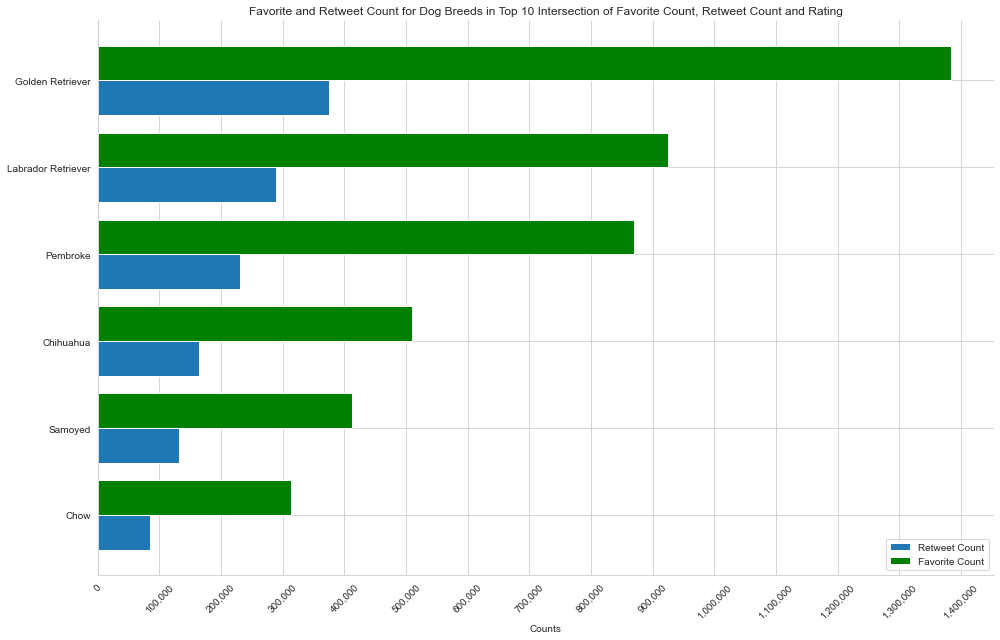

In [123]:
sns.set_style("whitegrid")
sns.color_palette("pastel")
x = np.arange(len(group_plt.index))
f, ax = plt.subplots(figsize=(14,9))
width = 0.4
ax.barh(x - width/2, group_plt.retweet_count.values, width, label='Retweet Count')
ax.barh(x + width/2, group_plt.favorite_count.values, width, label='Favorite Count', color='g')
ax.set_xlabel('Counts')
ax.xaxis.set_major_locator(mticker.MaxNLocator(15))
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ticks_loc], rotation=45)
ax.set_title('Favorite and Retweet Count for Dog Breeds in Top 10 Intersection of Favorite Count, Retweet Count and Rating')
ax.set_yticks(x)
ax.set_yticklabels(group_plt.index)
ax.legend(frameon=True)
f.tight_layout()
sns.despine()
plt.savefig('fav_retweet_top_10_report.png')
plt.show()